<a href="https://colab.research.google.com/github/aashrithresearch/endometrial-adenocarcinoma/blob/main/models/convnext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.vision.all import *
from fastai.callback.fp16 import *
import os
import torch
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/histopathological image dataset for ET'

In [3]:
print(os.listdir(path))

['EA', 'Non EA', 'feature_dict.p', 'lsh.p']


In [4]:
item_tfms = [Resize(299)]
batch_tfms = [*aug_transforms(size=299, max_warp=0), Normalize.from_stats(*imagenet_stats)]

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)

dls = dblock.dataloaders(path)

In [5]:
train_ds = dls.train_ds
dls = dblock.dataloaders(path)
from collections import Counter
class_counts = Counter([train_ds.items[i].parent.name for i in range(len(train_ds))])

print("Number of samples per class in the training set:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

Number of samples per class in the training set:
Non EA: 2206
EA: 436


In [6]:
valid_ds = dls.valid_ds
valid_class_counts = Counter([valid_ds.items[i].parent.name for i in range(len(valid_ds))])

print("Number of samples per class in the validation set:")
for cls, count in valid_class_counts.items():
    print(f"{cls}: {count}")

Number of samples per class in the validation set:
Non EA: 561
EA: 99


In [7]:
from math import ceil
batch = dls.one_batch()
batch_size = batch[0].shape[0]
ncols = 10
nrows = ceil(batch_size / ncols)

In [8]:
metrics = [
    accuracy,
    Precision(average='macro'),
    Recall(average='macro'),
    F1Score(average='macro')
           ]

In [9]:
learn = vision_learner(dls, convnext_large, metrics=metrics, cbs=[GradientAccumulation(n_acc=2)], loss_func=FocalLoss(), opt_func=Adam).to_fp16()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Large_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /root/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth
100%|██████████| 755M/755M [00:09<00:00, 86.4MB/s]


SuggestedLRs(valley=0.0008317637839354575)

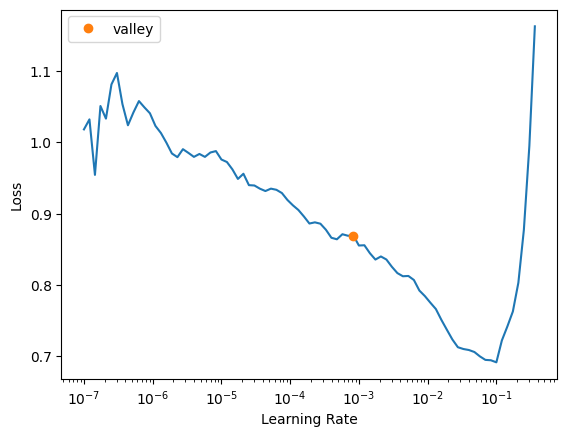

In [10]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(10, 1e-3, cbs=[SaveModelCallback(fname='model')])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.328051,0.102512,0.895455,0.792125,0.913547,0.832312,01:18
1,0.304431,0.135873,0.874242,0.761552,0.863636,0.795840,01:16
2,0.256437,0.054923,0.942424,0.877204,0.907903,0.891568,01:16
3,0.200185,0.085394,0.921212,0.829807,0.916221,0.864034,01:16
4,0.150623,0.044537,0.946970,0.888308,0.910576,0.898939,01:17
5,0.121162,0.039669,0.960606,0.939294,0.901961,0.919367,01:16
6,0.095024,0.030501,0.957576,0.922683,0.908497,0.915402,01:16
7,0.078351,0.030455,0.954545,0.919611,0.898396,0.908577,01:16
8,0.069941,0.031182,0.954545,0.910873,0.910873,0.910873,01:18
9,0.065760,0.031878,0.960606,0.917310,0.931075,0.924016,01:16


Better model found at epoch 0 with valid_loss value: 0.10251237452030182.
Better model found at epoch 2 with valid_loss value: 0.054923392832279205.
Better model found at epoch 4 with valid_loss value: 0.04453665390610695.
Better model found at epoch 5 with valid_loss value: 0.03966875374317169.
Better model found at epoch 6 with valid_loss value: 0.030501140281558037.
Better model found at epoch 7 with valid_loss value: 0.03045450896024704.


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

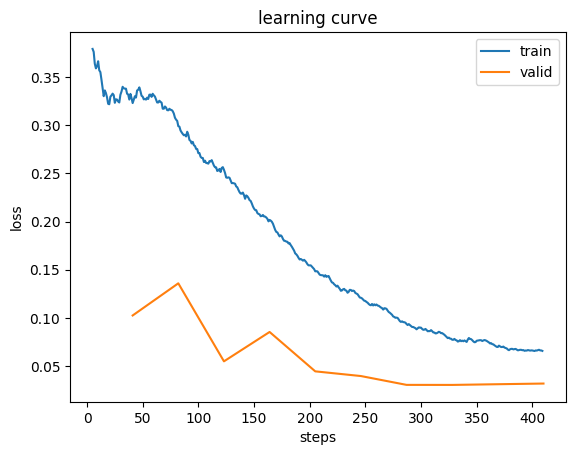

In [13]:
learn.recorder.plot_loss()